In [1]:
import os

In [2]:
head = "KITTI/data_scene_flow/training"

In [3]:
os.listdir(head)

['image_3',
 'disp_occ_1',
 'disp_noc_1',
 'viz_flow_occ_dilate_1',
 'viz_flow_occ',
 'disp_noc_0',
 'obj_map',
 'image_2',
 'flow_occ',
 'disp_occ_0',
 'flow_noc']

In [4]:
image_2_paths = sorted([os.path.join(head, "image_2", x) for x in os.listdir(head + "/image_2")])
image_3_paths = sorted([os.path.join(head, "image_3", x) for x in os.listdir(head + "/image_3")])
flow_paths = sorted([os.path.join(head, "flow_occ", x) for x in os.listdir(head + "/flow_occ")])

In [5]:
from PIL import Image

In [6]:
import matplotlib.pyplot as plt

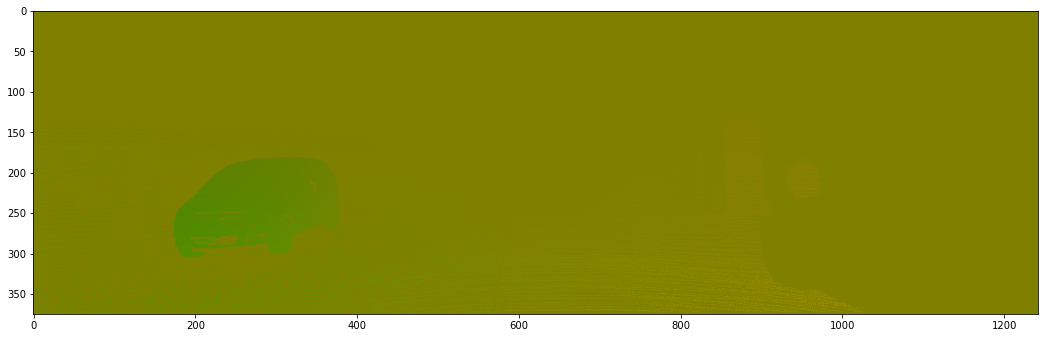

In [7]:
i = 0
plt.figure(figsize=(18, 18))
plt.imshow(Image.open(flow_paths[i]))


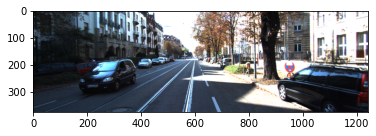

In [8]:
plt.imshow(Image.open(image_2_paths[i * 2 - 0]))

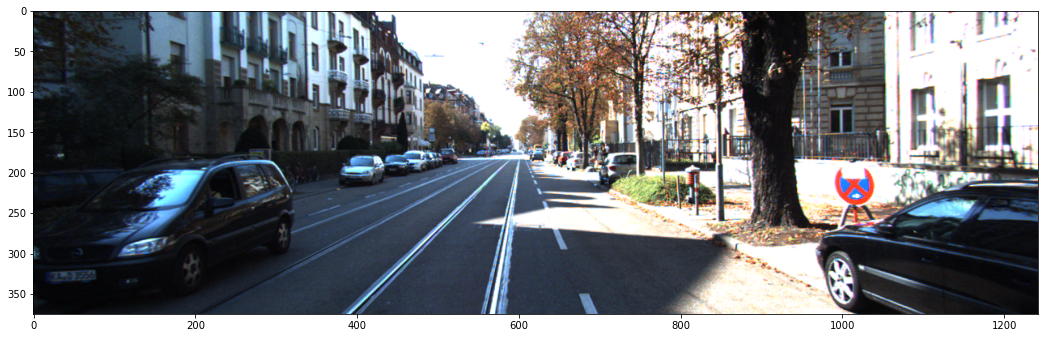

In [9]:
i = 0
plt.figure(figsize=(18, 18))
plt.imshow(Image.open(flow_paths[i]))
plt.imshow(Image.open(image_2_paths[i * 2 + 1]))

In [10]:
import torch

In [11]:
import torchvision


In [12]:
class KITTIData(torch.utils.data.Dataset):
    def __init__(self, image_path="image_2", flow_path="flow_occ"):
        super().__init__()
        head = "KITTI/data_scene_flow/training"
        self.image_paths = sorted([os.path.join(head, image_path, x) for x in os.listdir(os.path.join(head, image_path))])
        self.flow_paths = sorted([os.path.join(head, flow_path, x) for x in os.listdir(os.path.join(head, flow_path))])
        
        assert len(self.image_paths) == len(self.flow_paths) * 2
        
        self.images = []
        self.flows = []
        for i in range(len(self.image_paths)):
            self.images.append(Image.open(self.image_paths[i]))
        for i in range(len(self.flow_paths)):
            self.flows.append(Image.open(self.image_paths[i]))
        
    def __len__(self):
        return len(self.flow_paths)
        
    def __getitem__(self, i):
        first = torchvision.transforms.ToTensor()(self.images[i])
        second = torchvision.transforms.ToTensor()(self.images[i + 1])
        together = torch.cat((first, second), dim=0)
        label = torchvision.transforms.ToTensor()(self.flows[i])
        return together, label
        

In [13]:
dataset = KITTIData() 
dataset[0][0].shape

torch.Size([6, 375, 1242])

In [14]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
a = next(iter(dataloader))
a[0].shape

torch.Size([32, 6, 375, 1242])

In [15]:
epochs = 10
lr = 1e-3

In [16]:
from model import flownets, FlowNetS
from multiscaleloss import multiscaleEPE
model = FlowNetS() #insert model here
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #insert optimizer here
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loss_fn = torch.nn.MSELoss()
if torch.cuda.is_available():
    model.cuda()

/home/ubuntu/cs231n/util.py:11: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  "which is needed for FlowNetC", ImportWarning)


In [18]:
for epoch in range(epochs):
    for i, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        # outputs = model.forward(image)[0]
        outputs = model(image)
        h, w = label.size()[-2:]
        outputs = [torch.nn.functional.interpolate(outputs[0], (h,w)), *outputs[1:]]
        
        # loss = loss_fn(outputs, label)
        loss = multiscaleEPE(outputs, label)
        loss.backward()
        optimizer.step()

torch.Size([32, 2, 375, 1242]) torch.Size([32, 3, 375, 1242])


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1